In [1]:
%load_ext autoreload
%autoreload 2

In [421]:
import numpy as np
import pandas as pd
from math import log2, isclose
from nltk import ngrams
from itertools import combinations
from matplotlib import pyplot as plt
from nltk.tokenize import RegexpTokenizer, sent_tokenize

In [867]:
from matplotlib import cm
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Rectangle, Arc
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn')
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 10

legend_opts = {
    'fontsize':15,
    'frameon':True, 
    'framealpha':1,
    'facecolor':'white',
    'edgecolor':'black',
    'labelspacing':0.1}

def savefig(fig, filename, **kwargs):
    fig.savefig(f'../viz/{filename}', bbox_inches='tight', **kwargs)

# Tokenize texts

In [655]:
def replace_characters(text):
    replacement_rules = {'“': '"', '”': '"', '’': "'", '--': ','}
    for symbol, replacement in replacement_rules.items():
        text = text.replace(symbol, replacement)
    return text

In [656]:
def generate_tokenized_sentences(paragraph):
    word_tokenizer = RegexpTokenizer(r'[-\'\w]+')

    for sentence in sent_tokenize(paragraph):
        tokenized_sentence = word_tokenizer.tokenize(sentence)
        if tokenized_sentence:
            tokenized_sentence.append('<END>')
            yield tokenized_sentence

In [657]:
def tokenize_raw_text(raw_text_path, token_text_path):                
    with open(raw_text_path) as read_handle, open(token_text_path, 'w') as write_handle:
        for paragraph in read_handle:
            paragraph = paragraph.lower()
            paragraph = replace_characters(paragraph)
            
            for tokenized_sentence in generate_tokenized_sentences(paragraph):
                write_handle.write(','.join(tokenized_sentence))
                write_handle.write('\n')

In [658]:
tokenize_raw_text('../data/train_raw.txt', '../data/train_tokenized.txt')
tokenize_raw_text('../data/dev1_raw.txt', '../data/dev1_tokenized.txt')
tokenize_raw_text('../data/dev2_raw.txt', '../data/dev2_tokenized.txt')
tokenize_raw_text('../data/test1_raw.txt', '../data/test1_tokenized.txt')
tokenize_raw_text('../data/test2_raw.txt', '../data/test2_tokenized.txt')

# Count ngrams in text

In [659]:
def get_tokenized_sentences(file_name):
    with open(file_name) as file_handle:
        for sentence in file_handle.read().splitlines():
            tokenized_sentence = sentence.split(',')
            yield tokenized_sentence

In [660]:
class NgramCounter:
    def __init__(self, sentence_generator):
        self.sentence_generator = sentence_generator
        self.sentence_count = 0
        self.token_count = 0
        self.all_ngram_counts = {}
        for ngram_length in range(1, 6):
            self.all_ngram_counts[ngram_length] = {}
        self.count()
    
    def count(self):
        for sentence in self.sentence_generator:
            self.sentence_count += 1
            self.token_count += len(sentence)
            
            for ngram_length in range(1, 6):
                ngram_counts = self.all_ngram_counts[ngram_length]
                for ngram_position, ngram in enumerate(ngrams(sentence, ngram_length)):
                    ngram_count = ngram_counts.setdefault(ngram, {'start': 0, 'all': 0})
                    if ngram_position == 0:
                        ngram_count['start'] += 1
                    ngram_count['all'] += 1

In [661]:
train_sentence_generator = get_tokenized_sentences('../data/train_tokenized.txt')
dev1_sentence_generator = get_tokenized_sentences('../data/dev1_tokenized.txt')
dev2_sentence_generator = get_tokenized_sentences('../data/dev2_tokenized.txt')
test1_sentence_generator = get_tokenized_sentences('../data/test1_tokenized.txt')
test2_sentence_generator = get_tokenized_sentences('../data/test2_tokenized.txt')

In [662]:
train_counter = NgramCounter(train_sentence_generator)
dev1_counter = NgramCounter(dev1_sentence_generator)
dev2_counter = NgramCounter(dev2_sentence_generator)
test1_counter = NgramCounter(test1_sentence_generator)
test2_counter = NgramCounter(test2_sentence_generator)

In [663]:
train_counter.token_count, dev1_counter.token_count, dev2_counter.token_count, test1_counter.token_count, test2_counter.token_count

(321468, 353110, 450066, 461331, 333851)

## Unigram

In [724]:
class UnigramModel:
    def __init__(self, train_counter, smoothed=True):
        self.counter = train_counter
        
        self.unigram_counts = train_counter.all_ngram_counts[1].copy()
        self.unigram_counts[('<UNK>',)] = {'all': 0, 'start': 0}
        self.unigram_vocab = set(self.unigram_counts.keys())
        self.unigram_vocab_size = len(self.unigram_vocab)
        
        self.calculate_unigram_probs(smoothed)
    
    def calculate_unigram_probs(self, smoothed):
        self.probs = {}
        for unigram, unigram_count in self.unigram_counts.items():
            prob_nom = unigram_count['all'] + 1 if smoothed else unigram_count['all']
            prob_denom = self.counter.token_count + self.unigram_vocab_size if smoothed else self.counter.token_count
            self.probs[unigram] = prob_nom / prob_denom
            
    def calculate_avg_ll(self, test_counter):
        test_ll = 0
        test_unigram_counts = test_counter.all_ngram_counts[1]

        for unigram, unigram_count in test_unigram_counts.items():
            if unigram not in self.unigram_vocab:
                unigram = (('<UNK>',))
            unigram_train_prob = self.probs[unigram]
            unigram_test_count = unigram_count['all']
            unigram_ll = unigram_test_count * log2(unigram_train_prob)
            test_ll += unigram_ll
        
        avg_test_ll = test_ll / test_counter.token_count
        return avg_test_ll

In [725]:
train_unigram_model = UnigramModel(train_counter, smoothed=True)

In [726]:
train_unigram_model.calculate_avg_ll(dev1_counter), train_unigram_model.calculate_avg_ll(dev2_counter)

(-9.507387648094397, -10.168088076101292)

Visualization of smoothing

In [727]:
train_unigram_model_unsmoothed = UnigramModel(train_counter, smoothed=False)
dev1_unigram_model_unsmoothed = UnigramModel(dev1_counter, smoothed=False)
dev2_unigram_model_unsmoothed = UnigramModel(dev2_counter, smoothed=False)

In [729]:
sorted_train_unigrams = []
sorted_train_unigram_percents = []

for ngram, ngram_prob in sorted(train_unigram_model_unsmoothed.probs.items(), key=lambda item: item[1], reverse=True):
    sorted_train_unigrams.append(ngram)
    sorted_train_unigram_percents.append(ngram_prob*100)

In [730]:
smoothed_percents_80_20 = np.array(sorted_train_unigram_percents)*0.8 + 0.2/(train_unigram_model_unsmoothed.unigram_vocab_size)*100

In [731]:
dev1_unigram_percents = [dev1_unigram_model_unsmoothed.probs.get(unigram, 0)*100 for unigram in sorted_train_unigrams]
dev2_unigram_percents = [dev2_unigram_model_unsmoothed.probs.get(unigram, 0)*100 for unigram in sorted_train_unigrams]
sorted_train_unigrams = [unigram[0] for unigram in sorted_train_unigrams]

Text(0, 0.5, '% in text')

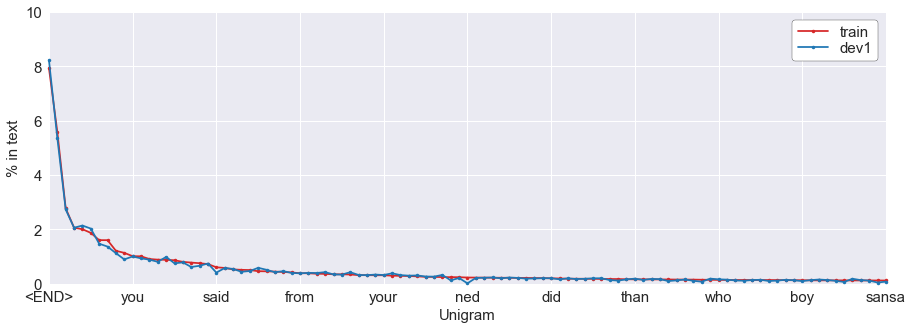

In [805]:
fig, ax = plt.subplots(figsize=(15, 5))
xlim = 101
ax.plot(np.array(sorted_train_unigram_percents[:xlim]), '.-', label='train', color='tab:red', clip_on=False)

ax.plot(np.array(dev1_unigram_percents[:xlim]), '.-', label='dev1', color='tab:blue', clip_on=False)
# ax.plot(np.array(dev2_unigram_percents[:xlim]), '.-', label='dev2', color='tab:green', clip_on=False)
# ax.plot(np.array(smoothed_percents_80_20[:xlim]), '.-', label='smoothed', color='tab:orange', clip_on=False)
xticks = range(0, xlim+1, 10)
xticklabels = np.array(sorted_train_unigrams)[xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

ax.legend(**legend_opts)
ax.set_xlim(0, xlim-1)
ax.set_ylim(0, 10)
ax.set_xlabel('Unigram')
ax.set_ylabel('% in text')

## Multigram model

In [764]:
class MultigramModel(UnigramModel):
    def __init__(self, train_counter):
        super().__init__(train_counter, smoothed=False)
        self.uniform_prob = 1 / self.unigram_vocab_size
        self.calculate_multigram_probs()

    def calculate_multigram_probs(self):
        self.start_probs = {}
        for n in range(2, 6):
            for ngram, ngram_count in self.counter.all_ngram_counts[n].items():
                prevgram = ngram[:-1]
                if ngram_count['start']:
                    prob_nom = ngram_count['start']
                    prob_denom = self.counter.all_ngram_counts[n - 1][prevgram]['start']
                    self.start_probs[ngram] = prob_nom / prob_denom
                
                prob_nom = ngram_count['all']
                prob_denom = self.counter.all_ngram_counts[n - 1][prevgram]['all']
                self.probs[ngram] = prob_nom / prob_denom
                
                
    def get_test_condprobs(self, test_file):
        test_token_count = sum(len(sentence) for sentence in get_tokenized_sentences(test_file))
        test_prob_matrix = np.zeros((test_token_count, 6))
        test_prob_matrix[:, 0] = self.uniform_prob

        row = 0
        for sentence_index, sentence in enumerate(get_tokenized_sentences(test_file)):
            for token_position, token in enumerate(sentence):
                for ngram_length in range(1, 6):
                    ngram_start = token_position + 1 - ngram_length
                    ngram_end = token_position + 1
                    if ngram_start >= 0:
                        ngram = tuple(sentence[ngram_start:ngram_end])
                        test_prob_matrix[row, ngram_length] = self.probs.get(ngram, 0)
                    else:
                        start_ngram = tuple(sentence[0:ngram_end])
                        test_prob_matrix[row, ngram_length] = self.start_probs.get(start_ngram, 0)
                row += 1

        return test_prob_matrix

In [765]:
train_multigram_model = MultigramModel(train_counter)

In [858]:
train_prob_matrix = train_multigram_model.get_test_condprobs('../data/train_tokenized.txt')
dev1_prob_matrix = train_multigram_model.get_test_condprobs('../data/dev1_tokenized.txt')
dev2_prob_matrix = train_multigram_model.get_test_condprobs('../data/dev2_tokenized.txt')

In [781]:
def calculate_avg_ll(prob_matrix, cols, weights=None):
    if weights is None:
        weights = np.ones(len(cols)) / len(cols)
    return np.log2((prob_matrix[:, cols] * np.array(weights)).sum(axis=1)).mean()

In [1047]:
train_avg_lls = []
dev1_avg_lls = []
dev2_avg_lls = []

unigram_weights = np.linspace(0, 0.999, 100)
for unigram_weight in unigram_weights:
    uniform_weight = 1 - unigram_weight
    train_avg_lls.append(calculate_avg_ll(train_prob_matrix, [0, 1], weights=[uniform_weight, unigram_weight]))
    dev1_avg_lls.append(calculate_avg_ll(dev1_prob_matrix, [0, 1], weights=[uniform_weight, unigram_weight]))
    dev2_avg_lls.append(calculate_avg_ll(dev2_prob_matrix, [0, 1], weights=[uniform_weight, unigram_weight]))

(-14, -9)

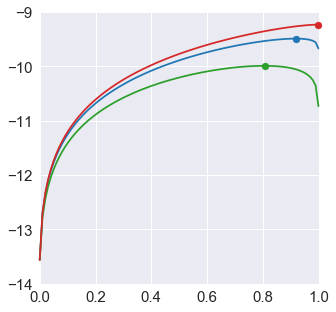

In [1048]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(unigram_weights, dev1_avg_lls, color='tab:blue', clip_on=False)
ax.plot(unigram_weights, dev2_avg_lls, color='tab:green', clip_on=False)
ax.plot(unigram_weights, train_avg_lls, color='tab:red', clip_on=False)

ax.scatter(unigram_weights[np.argmax(train_avg_lls)], np.max(train_avg_lls), color='tab:red', clip_on=False)
ax.scatter(unigram_weights[np.argmax(dev1_avg_lls)], np.max(dev1_avg_lls), color='tab:blue', clip_on=False)
ax.scatter(unigram_weights[np.argmax(dev2_avg_lls)], np.max(dev2_avg_lls), color='tab:green', clip_on=False)

ax.set_xlim(0, 1)
ax.set_ylim(-14, -9)

In [864]:
def plot_interpolate_with_uniform(ax, prob_matrix, ngram_weight, text_location, show_legend=True):
    cmap = cm.winter_r
    ngram_lengths = list(range(1, 6))
    uniform_weight = 1 - ngram_weight

    avg_lls = []
    for ngram_length in ngram_lengths:
        avg_ll = calculate_avg_ll(prob_matrix, [0, ngram_length], weights=[uniform_weight, ngram_weight])
        avg_lls.append(avg_ll)
    ax.plot(ngram_lengths, avg_lls, 'o-', label=f'{ngram_weight:.2f}', color=cmap(ngram_weight))
    if show_legend:
        ax.legend(title='Fraction of\nngram model', bbox_to_anchor=(1.04, 0), loc='lower left', **legend_opts)
    if text_location == 'right':
        ax.text(5.1, avg_lls[-1], s=f'{ngram_weight:.2f}', fontsize=12, ha='left', va='center', color=cmap(ngram_weight))
    else:
        ax.text(0.9, avg_lls[-1], s=f'{ngram_weight:.2f}', fontsize=12, ha='right', va='center', color=cmap(ngram_weight))
        
    ax.set_xlim(0, 6)
    ax.set_xticks(range(1, 6))
    ax.set_yticks(np.arange(-20, 1, 5))
    ax.set_ylim(-20, 0)
    
    ax.set_xlabel('ngram')
    ax.set_ylabel('Average log likelihood')

Text(0.5, 1.0, 'dev2')

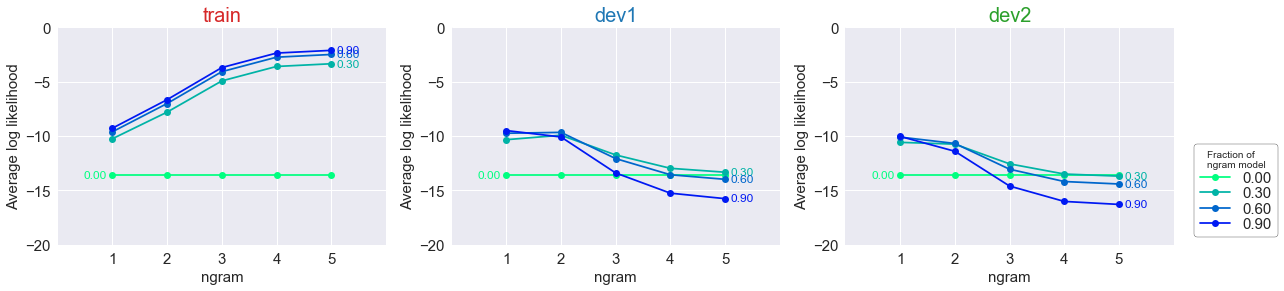

In [878]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
text_locations_by_weight = {0: 'left', 0.3: 'right', 0.6: 'right', 0.9: 'right'}

for ngram_weight, text_location in text_locations_by_weight.items():
    plot_interpolate_with_uniform(ax1, train_prob_matrix, ngram_weight=ngram_weight, text_location=text_location, show_legend=False)
    plot_interpolate_with_uniform(ax2, dev1_prob_matrix, ngram_weight=ngram_weight, text_location=text_location, show_legend=False)
    plot_interpolate_with_uniform(ax3, dev2_prob_matrix, ngram_weight=ngram_weight, text_location=text_location)
    
ax1.set_title('train', color='tab:red')
ax2.set_title('dev1', color='tab:blue')
ax3.set_title('dev2', color='tab:green')

In [1000]:
ngram_weight = 0.9
uniform_weight = 1 - ngram_weight
dev1_n_tokens = len(dev1_prob_matrix)
dev2_n_tokens = len(dev2_prob_matrix)

dev1_avg_lls = []
dev1_new_ngram_fractions = []
dev2_avg_lls = []
dev2_new_ngram_fractions = []

for n in range(1, 6):
    dev1_new_ngram_fractions.append((dev1_prob_matrix[:, n]==0).sum() / dev1_n_tokens)
    dev2_new_ngram_fractions.append((dev2_prob_matrix[:, n]==0).sum() / dev2_n_tokens)
    dev1_avg_lls.append(calculate_avg_ll(dev1_prob_matrix, [0, n], weights=[uniform_weight, ngram_weight]))
    dev2_avg_lls.append(calculate_avg_ll(dev2_prob_matrix, [0, n], weights=[uniform_weight, ngram_weight]))

Text(0, 0.5, 'Average log likelihood')

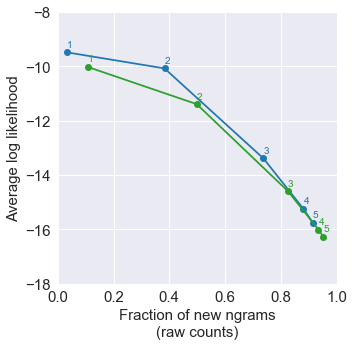

In [1013]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(dev1_new_ngram_fractions, dev1_avg_lls, 'o-', color='tab:blue', clip_on=False)
ax.plot(dev2_new_ngram_fractions, dev2_avg_lls, 'o-', color='tab:green', clip_on=False)

for n in range(1, 6):
    ax.text(dev1_new_ngram_fractions[n-1], dev1_avg_lls[n-1]+0.2, s=n, color='tab:blue')
    ax.text(dev2_new_ngram_fractions[n-1], dev2_avg_lls[n-1]+0.2, s=n, color='tab:green')

ax.set_xlim(0, 1)
ax.set_ylim(-18, -8)
ax.set_xlabel('Fraction of new ngrams\n(raw counts)')
ax.set_ylabel('Average log likelihood')

In [1016]:
train_avg_lls = []
dev1_avg_lls = []
dev2_avg_lls = []

ngrams = []
for n in range(6):
    ngrams.append(n)
    train_avg_lls.append(calculate_avg_ll(train_prob_matrix, ngrams))
    dev1_avg_lls.append(calculate_avg_ll(dev1_prob_matrix, ngrams))
    dev2_avg_lls.append(calculate_avg_ll(dev2_prob_matrix, ngrams))

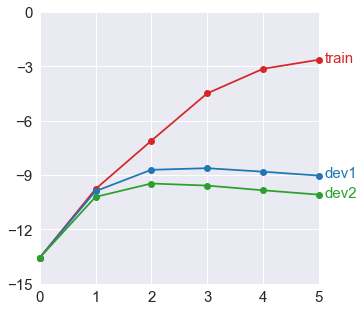

In [1032]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(ngrams, train_avg_lls, '-o', color='tab:red', clip_on=False)
ax.plot(ngrams, dev1_avg_lls, '-o', color='tab:blue', clip_on=False)
ax.plot(ngrams, dev2_avg_lls, '-o', color='tab:green', clip_on=False)

ax.text(5.1, train_avg_lls[-1]+0.1, s='train', va='center', color='tab:red', fontsize=15)
ax.text(5.1, dev1_avg_lls[-1]+0.1, s='dev1', va='center', color='tab:blue', fontsize=15)
ax.text(5.1, dev2_avg_lls[-1]+0.1, s='dev2', va='center', color='tab:green', fontsize=15)

ax.set_xlim(0, 5)
ax.set_ylim(-15, 0)
ax.set_yticks(range(-15, 1, 3))